<body>
    <font size="2">Florian Schnabel, 11807470, SS 2023</font><br />
</body>

# Exercise 4 - Coupled Simulation of latent heat effects

This script is an extension of the script elaborated in {numref}`sec:Ex1`. It aims to calculate the temperature and moisture field across a multi-layered building component. Such a multi-layered building component is shown in {numref}`fig:multilayComp`.

```{figure} ./Figures/BuildingComponent.png
---
width: 350px
name: fig:multilayComp
---
Multi-layered building component and discretisation requirements [excersise Description]
```

Unlike in the version shown in {numref}`sec:Ex1` the following restrictions introduced, to reduce the complexity of the coupled problem.
* the script is only aplicable to mineral wool
* both density and heatcapacity will be kept constant
* for the heat conductivity and the vapor diffusion coefficient are linear functions

## Balance Equations

To consider the latent heat effect the time derivative of the Temperaturefield (seen in {eq}`gl:heatflow`) is expandend by the moisture induced pressure field.  The equation for heat conduction including latent heat effect is shown in {eq}`gl:heatmoist`:
 
$$\rho \cdot c \cdot \frac{dT}{dt} = \nabla (\lambda \nabla T + L_v \delta_v \nabla p_{vap}) $$ (gl:heatmoist)

The introduced moisture field is defined by the balance euqation for moisture transport ({eq}`gl:moist`):

$$ \frac{dw}{dt} =  \nabla (\delta_v \nabla p_{vap}) $$


## Space discretisation

The discretisation of ({eq}gl:heatmoist) and ({eq}gl:moist) is done similar to section {numref}`sec:Ex1` using the finite volume method and a representation as RC-Networks. Evaluating for a cell P surrounded by a cell to the east and west results in ({eq}`gl:heatmoistdis`) and ({eq}`gl:moistdis`):

$$\rho \cdot c \cdot \frac{T^{n+1}_P - T^n_P  }{\Delta t} = \frac{\lambda \cdot ( T^n_E - 2T^n_P + T^n_W) }{\Delta x^2} + \frac{L_v \cdot \delta_v \cdot ( p_{vap,E}^n - 2 p_{vap,P}^n +  p_{vap,W}^n) }{\Delta x^2} $$ (gl:heatmoistdis)

$$\frac{w_{P}^{n+1} - w_{P}^n }{\Delta t} =\frac{\delta_v \cdot ( p_{vap,E}^n - 2 p_{vap,P}^n +  p_{vap,W}^n) }{\Delta x^2} $$ (gl:moistdis)

or written in matrix notation:

$$\rho \cdot c \cdot \frac{T^{n+1}_P - T^n_P  }{\Delta t} = \lambda  \cdot K \cdot T + L_v \cdot \delta_v  \cdot M \cdot p_{vap} $$ (gl:heatmoistdis)

Unlike in the version shown in {numref}`sec:Ex1` the conductivity is not included in the $K$ matrix. This leads to a constant conductivity matrix, at the cost of an error at the surface resistance. The conductivity matrix K can therefore be Written as follows:

$$ K = \left [ 
\begin{array}{ccccccc}
    0 & 0 & 0 & 0 & (...) & 0 & 0 & 0  & 0\\
    K_{BC,1} & -(K_{BC,1} + \frac{1}{\Delta x^2}) & \frac{1}{\Delta x^2} & 0 & (...) & 0 & 0 & 0 & 0\\
    0 & \frac{1}{\Delta x^2} & -\frac{2}{\Delta x^2} & \frac{1}{\Delta x^2} & (...) & 0 & 0  & 0 & 0\\
    (...) & (...) & (...) & (...) & (...) & (...) & (...)  & (...) & (...)\\
    0 & 0 & 0 & 0 &(...) & \frac{1}{\Delta x^2} & -\frac{2}{\Delta x^2} & \frac{1}{\Delta x^2} & 0 \\
    0 & 0 & 0 & 0 &(...) & 0 & 1 & -(\frac{1}{\Delta x^2} + K_{BC,2}) & K_{BC,2} \\
    0 & 0 & 0 & 0 &(...) & 0 & 0 & 0 & 0 \\
\end{array}
\right] $$

And for Cells at the boundary:

$$ K_{BC,1} = K_{0.5} = \frac{1}{R_{s,1}  \cdot \Delta x \cdot \lambda + 0.5 \cdot \Delta x^2} $$

To allow a consturction on $K$ outside of the integrator, $\lambda_1$ is constant. This results in the above mentioned error. $M$ is calculated the in the same way as:


$$ M = \left [ 
\begin{array}{ccccccc}
    0 & 0 & 0 & 0 & (...) & 0 & 0 & 0  & 0\\
    M_{BC,1} & -(M_{BC,1} + \frac{1}{\Delta x^2}) & \frac{1}{\Delta x^2} & 0 & (...) & 0 & 0 & 0 & 0\\
    0 & \frac{1}{\Delta x^2} & -\frac{2}{\Delta x^2} & \frac{1}{\Delta x^2} & (...) & 0 & 0  & 0 & 0\\
    (...) & (...) & (...) & (...) & (...) & (...) & (...)  & (...) & (...)\\
    0 & 0 & 0 & 0 &(...) & \frac{1}{\Delta x^2} & -\frac{2}{\Delta x^2} & \frac{1}{\Delta x^2} & 0 \\
    0 & 0 & 0 & 0 &(...) & 0 & 1 & -(\frac{1}{\Delta x^2} + M_{BC,2}) & M_{BC,2} \\
    0 & 0 & 0 & 0 &(...) & 0 & 0 & 0 & 0 \\
\end{array}
\right] $$

$$ K_{BC,1} = K_{0.5} = \frac{1}{h_{v}  \cdot \Delta x \cdot \delta_v + 0.5 \cdot \Delta x^2} $$

with the surface mass transfer coefficient $h_v = 3 \cdot 10^{-8}\ m/s$  {cite}`walther2021`.

## Time Integration

The integration will be achieved bay using a solver from the **scipy** library.

## Implementation

In [1]:
%reset

#Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
import copy as copy

In [2]:
class boundary:
    def __init__(self, temperature1, temperature2, resistance1, resistance2,humidity1, humidity2,  humresistance1, humresistance2):
        self.temperature1 = temperature1
        self.temperature2 = temperature2
        self.resistance1 = resistance1
        self.resistance2 = resistance2
        self.humidity1 = humidity1
        self.humidity2 = humidity2
        self.humresistance1 = humresistance1
        self.humresistance2 = humresistance2

In [3]:
class layer:
    # n summarizes the number of all cells
    # start value for n = number of boundaries, makes place for boundary temp
    n=2
    # width sumarizes the thickness of all layers
    width_sum =0

    def __init__(self, material, width, n_cells, thermConduct, heatCap, density):
        self.material = material
        self.width = width
        self.n_cells = n_cells
        self.thermConduct = thermConduct
        self.heatCap = heatCap
        self.density = density

        # Adding number of cells and width to class counters
        layer.n += self.n_cells
        layer.width_sum += self.width

### Construction of the layer and boundary objects
Input Values according to the excersise description with the following units:
* [$\lambda$]= $W m^{-2} K^{-1}$
* [$R_s$]= $W^{-1} m^{2} K$
* [$T$]= $^\circ C$
* [$t$]= $m$
* [$c$]= $J kg^{-1} K^{-1}$
* [$\rho$]= $kg m^{-3}$


In [4]:
boundaries = boundary(20,0,0.13,0.13,80,90, 1/(3e-8), 1/(3e-8))

#Beware, each layer must have at least 3 cells!
layers = []
layers.append(layer("Dämmung", 0.4, 40, 0.04, 1000, 160))

### Sorption Isotherm

In [5]:
def fc_w_phi(phi):
    a=1000
    b=250*1e-6
    c=1
    res= a/np.power(1-np.log(phi/100)/b,1/c)
    return res * 1e-3

In [6]:
def fc_phi_w(w):
    a=1000
    b=250e-6
    c=1
    phi= np.exp(b*(1-(a/w/1000)**c)) * 100 
    return phi 

In [7]:
a=[]

for i in range(1,100):
    a.append(fc_w_phi(i))

Text(0.5, 1.0, 'Sorption Isotherm - mineral wool')

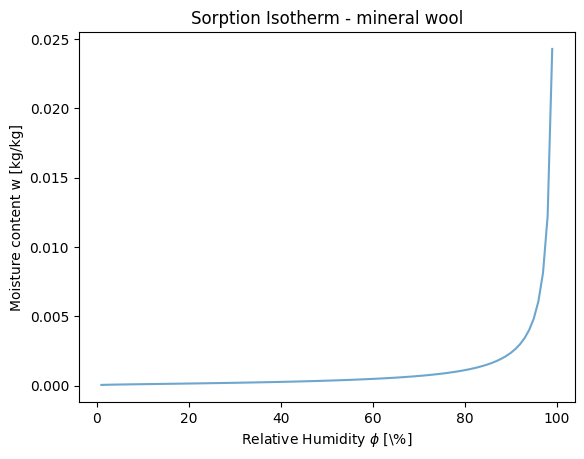

In [8]:
plt.xlabel("Relative Humidity $\phi$ [\%]")
plt.ylabel("Moisture content w [kg/kg]")

plt.plot(range(1,100,1), a,  alpha=0.65)
plt.title("Sorption Isotherm - mineral wool")

### Water permability, saturated vapor pressure and heat conductivity

In [9]:
def fc_psat_T (T):
    #    return 610.5 * np.exp( 17.269*T / (237.3+T)) # T>0
    #    return 610.5 * np.exp( 21.875*T / (265.5+T)) # T<0
    return np.power(10, 7.625*T/(241+T)+2.7877) # Lehrbuch

In [10]:
def fc_deltapv_T (w,T):
    a= (22.2 + 0.14*T) * 10**-6
    b= -a 
    return a+b*w 

In [11]:
def fc_lambda_w (w):
    return 0.04 + 6*w

In [12]:
def update_Cm(w,phi,T):
	epsilon=0.001*np.min(w)
	wp=w+epsilon
	phip=fc_phi_w(wp)
	dw=abs(wp-w)
	dphi=abs(phip-phi)/100
	pvs=fc_psat_T(T)
	Cm=dw/dphi/pvs
	return Cm

In [13]:
Lv = 2503000

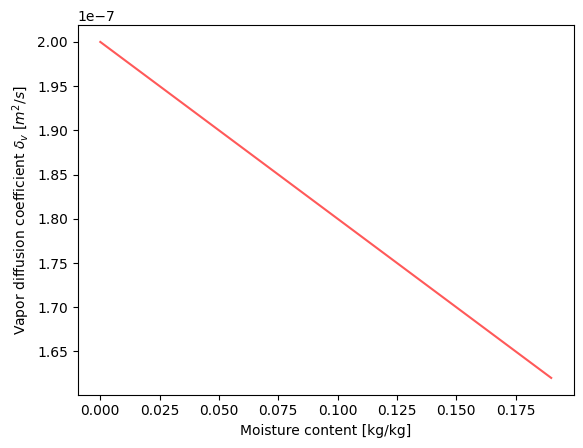

In [14]:
b = fc_deltapv_T(np.array(np.arange(0,0.2,0.01)),-22.0/0.14)

plt.ylabel("Vapor diffusion coefficient $\delta_v$ [$m^2/s$]")
plt.xlabel("Moisture content [kg/kg]")

plt.plot(np.arange(0,0.2,0.01), b, alpha=0.65, color="red")



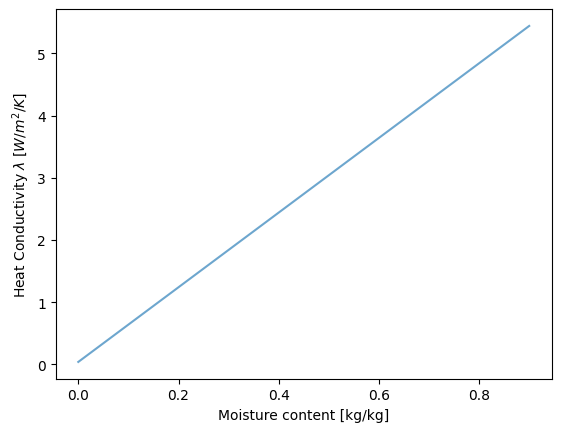

In [15]:
b = fc_lambda_w(np.arange(0,1,0.1))

plt.ylabel("Heat Conductivity $\lambda$ [$W/m^2/K$]")
plt.xlabel("Moisture content [kg/kg]")

plt.plot(np.arange(0,1,0.1), b, alpha=0.65)

### Construction of the conductivity matrix $K$ and $M$

In [16]:
# reference number of cells to increase readability
n = layer.n

# Initialising conductivity matrix K and M
K = np.zeros((n,n))

# iterater to keep track of cell numbers
counter = 1
for layer in layers:
    #step size for the current layer
    deltaX=layer.width / layer.n_cells

    #initialize empty conductivity matrix for the current layer
    K_current = np.zeros((n,n))

    #defining the "east" and "west" conductivity for interior cells
    K_current[range(counter+1,counter+layer.n_cells),range(counter,counter+layer.n_cells-1)]= 1 / deltaX**2
    K_current[range(counter,counter+layer.n_cells-1),range(counter+1,counter+layer.n_cells)]= 1 / deltaX**2
    
    #defining the "east" and "west" conductivity for the last and first cell of each layer
    #these are added up between layers, thus half the cell distance and inverted
    K_current[(counter,counter+layer.n_cells),(counter-1,counter+layer.n_cells-1)]= 1 / 2 *   deltaX**2
    K_current[(counter-1,counter+layer.n_cells-1),(counter,counter+layer.n_cells)]= 1/ 2  * deltaX**2
    
    K += K_current
    
    #Inverting the Konductivity between surfaces after adding them
    K[(counter),(counter-1)] = 1/K[(counter),(counter-1)]
    K[(counter-1),(counter)] = 1/K[(counter-1),(counter)]

        
    counter += layer.n_cells

In [17]:
# Initialising M as a copy of K
M=copy.deepcopy(K)

In [18]:
# Boundary Conditions for K
deltaX_l = (layers[0].width / layers[0].n_cells)
deltaX_r = (layers[-1].width / layers[-1].n_cells)
K_l =  1/(boundaries.resistance1 *  layers[0].thermConduct * deltaX_l+ 0.5 *deltaX_l**2)
K_r =  1/(boundaries.resistance2 * layers[-1].thermConduct *deltaX_r+ 0.5 *deltaX_r**2)
K[1,0] = K_l
K[len(K)-2,len(K)-1] = K_r

In [19]:
# Boundary Conditions for M
deltapv_l=fc_deltapv_T(fc_w_phi(boundaries.humidity1),boundaries.temperature1 )
deltapv_r=fc_deltapv_T(fc_w_phi(boundaries.humidity2),boundaries.temperature2 )
M_l =  1/(2 *deltaX_l**2)
M_r =  1/(2 *deltaX_r**2)
M[1,0] = M_l
M[len(K)-2,len(K)-1] = M_r

In [20]:
#The diagonal of the conductivity matrix is defined as the negative sum of the 
#"east" and "west" conductivity for the cell
K[range(0,len(K)),range(0,len(K))]= -np.sum(K,axis=1)
M[range(0,len(M)),range(0,len(M))]= -np.sum(M,axis=1)

#free first and last row; this leads to constant values at the boundaries
K[0,:]=0
K[-1,:]=0

M[0,:]=0
M[-1,:]=0

In [21]:
print(K)

[[     0.              0.              0.         ...      0.
       0.              0.        ]
 [  9803.92156863 -19803.92156863  10000.         ...      0.
       0.              0.        ]
 [     0.          10000.         -20000.         ...      0.
       0.              0.        ]
 ...
 [     0.              0.              0.         ... -20000.
   10000.              0.        ]
 [     0.              0.              0.         ...  10000.
  -19803.92156863   9803.92156863]
 [     0.              0.              0.         ...      0.
       0.              0.        ]]


In [22]:
print(M)

[[     0.      0.      0. ...      0.      0.      0.]
 [  5000. -15000.  10000. ...      0.      0.      0.]
 [     0.  10000. -20000. ...      0.      0.      0.]
 ...
 [     0.      0.      0. ... -20000.  10000.      0.]
 [     0.      0.      0. ...  10000. -15000.   5000.]
 [     0.      0.      0. ...      0.      0.      0.]]


### Calculating the temperature field

In [23]:
#initialize the temperaturefield
vec_T_w = np.ones(layer.n*2) * 0.001
vec_T_w[0:layer.n-1] = 20
vec_T_w[layer.n:layer.n*2] = fc_w_phi(50)

#Insert Boundary Konditions
vec_T_w[0]= boundaries.temperature1
vec_T_w[layer.n-1]= boundaries.temperature2
#Insert Boundary Konditions
vec_T_w[layer.n]= fc_w_phi(boundaries.humidity1)
vec_T_w[-1]= fc_w_phi(boundaries.humidity2)


## Variant 1 - Heat conductivity

In [24]:
T = vec_T_w[0:layer.n]

In [25]:
thermConduct = fc_lambda_w(np.ones(len(T)) * 0)

In [26]:
def dT_dt(t,T):
    delta_T =  thermConduct * np.dot(K,T) /(layers[0].heatCap * layers[0].density)
    return delta_T

In [27]:
result_heat = scipy.integrate.solve_ivp(dT_dt,(0,1800000),T,method="Radau",atol=1e-7,rtol=1e-5)

## Variant 2 - Coupled Simulation

In [28]:
def dt_w_dt(t,vec_T_w):
    #Splitting up temp and water vector
    T = vec_T_w[0:layer.n]
    w = vec_T_w[layer.n:layer.n*2]
    
    c = 1000
    rho = 160
    Lv = 2503000
    
    phi = fc_phi_w(w)
    thermConduct = fc_lambda_w(w)
    deltapv = fc_deltapv_T(w,T)
    
    
    
    pvap = fc_psat_T(T) * phi /100
    
    delta_T =  (thermConduct * np.dot(K,T) +  deltapv * Lv * np.dot(M,pvap) )/(c*rho)
    
    delta_w =  deltapv *  np.dot(M,pvap) 
    
    return np.append(delta_T,delta_w)

In [29]:
#dt_w_dt(t,vec_T_w)
result_coupled = scipy.integrate.solve_ivp(dt_w_dt,(0,1800000),vec_T_w,method="Radau",atol=1e-7,rtol=1e-5)

KeyboardInterrupt: 

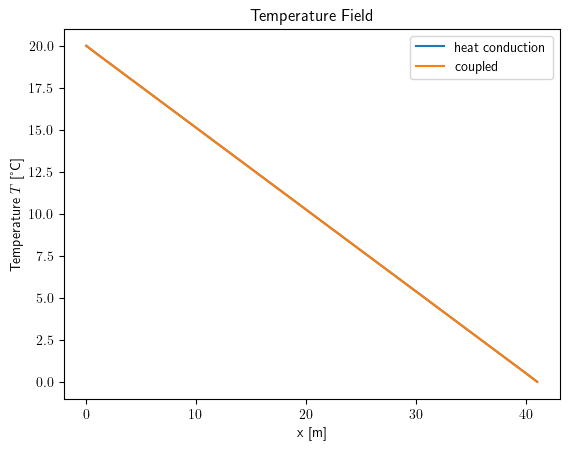

In [164]:
res_T_coup =[]
res_T_heat=[]
for i in range(layer.n):
    res_T_coup.append(result_coupled.y[i,-1])
    res_T_heat.append(result_heat.y[i,-1])
    
plt.ylabel("Temperature $T$ [°C]")
plt.xlabel("x [m]")

plt.title("Temperature Field")

 
plt.plot(range(layer.n), res_T_heat, label="heat conduction")
plt.plot(range(layer.n), res_T_coup, label="coupled")
plt.legend()

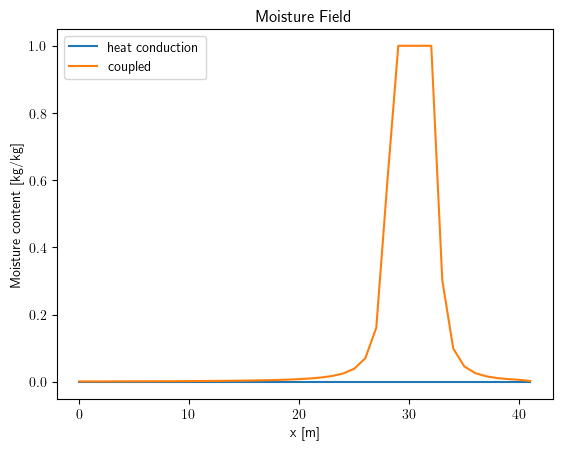

In [165]:
res_w_heat =[]
res_w_coup=[]
for i in range(layer.n,layer.n*2):
    res_w_coup.append(result_coupled.y[i,-1])
    res_w_heat.append(0)
    
plt.ylabel("Moisture content [kg/kg]")
plt.xlabel("x [m]")

plt.title("Moisture Field")

 
plt.plot(range(layer.n), res_w_heat, label="heat conduction")
plt.plot(range(layer.n), res_w_coup, label="coupled")
plt.legend()


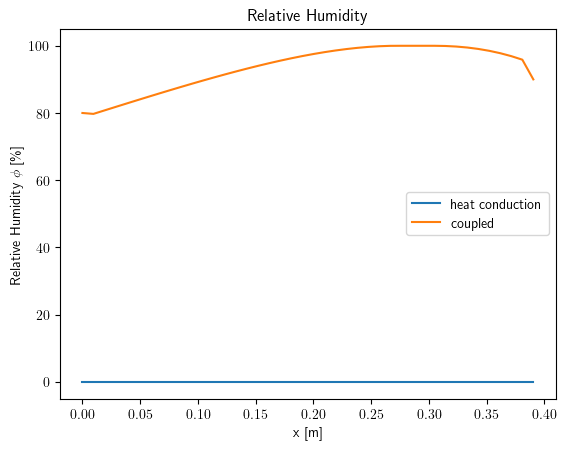

In [170]:
plt.ylabel("Relative Humidity $\phi$ [\%]")
plt.xlabel("x [m]")

plt.title("Relative Humidity")

 
plt.plot(np.arange(0,width_sum,width_sum/layer.n), a, label="heat conduction")
plt.plot(np.arange(0,width_sum,width_sum/layer.n), fc_phi_w(np.array(res_w_coup)), label="coupled")
plt.legend()

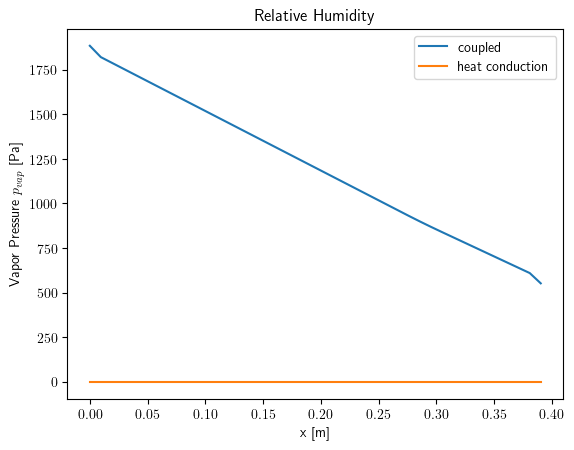

In [174]:
plt.ylabel("Vapor Pressure $p_{vap}$ [Pa]")
plt.xlabel("x [m]")

plt.title("Relative Humidity")

res_pvap_coup = fc_psat_T(np.array(res_T_coup)) * fc_phi_w(np.array(res_w_coup)) /100
plt.plot(np.arange(0,width_sum,width_sum/layer.n), res_pvap_coup, label="coupled")
plt.plot(np.arange(0,width_sum,width_sum/layer.n), a, label="heat conduction")
plt.legend()

## References


```{bibliography}
:style: plain
```